Signal correlation panel created


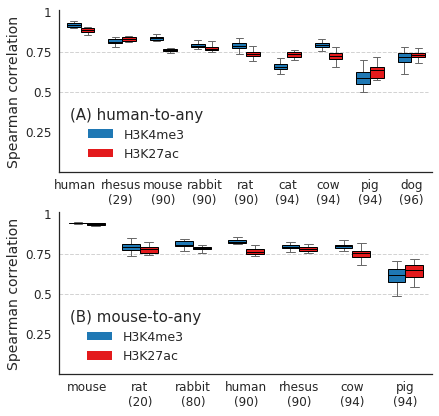

In [11]:
%matplotlib inline

import os as os
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle
from sklearn.metrics import auc, roc_auc_score, \
    average_precision_score, precision_recall_curve, roc_curve

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import numpy as np
import numpy.random as rng
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

from sklearn.metrics import precision_recall_fscore_support as pfm

# What is this?
# Plot signal correlations
# of measured/transferred signal
# relative to validation data
# from Villar et al.

date = '20180808'

run_sigcorr_valid = True
save_figures = True
save_diss = True

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
corr_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_signal_validation')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
diss_folder = '/home/pebert/work/code/mpggit/dissertation/Figures'

color_k4 = tuple(x / 255 for x in [31,120,180])
color_k27 = tuple(x / 255 for x in [227,26,28])

def exec_status():
    cache_file = os.path.join(cache_dir, '{}_plot_sigcorr_valid.pck'.format(date))
    
    if not os.path.isfile(cache_file):
        correlations = cache_data(cache_file)
    else:
        with open(cache_file, 'rb') as cache:
            correlations = pck.load(cache)

    species, lca = read_references(species_file, lca_times_file)
    
    fig, exart = plot_corr_boxes(correlations,
                                 ['hg19', 'mm9'], species, lca,
                                 ['A', 'B'], save_diss)
    if save_figures:
        outname = 'fig_XAB_sigcorr_validation'
        if save_diss:
            out_folder = diss_folder
            subfolder = 'crossspecies'
        else:
            subfolder = 'main'
        
        if not save_diss:
            outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')

            outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        
        outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    
    return True


def get_filename_parser(which):
    
    if which == 'map':
        # roicorr_EV24_rn5_liver_H3K27ac_vs_EE12_rn5_liver_H3K27ac.from.mm9.mapsig_reg5p.json
        def get_infos(fname):
            parts = fname.split('_')
            eid1, eid2 = parts[1], parts[6]
            mark1 = parts[4]
            qry = parts[2]
            trg = parts[9].split('.')[-2]
            mark2 = parts[9].split('.')[0]
            return trg, qry, eid1, eid2, mark1, mark2
    else:
        # roicorr_EV20_hg19_liver_H3K4me3_vs_EV20_hg19_liver_H3K27ac_reg5p.json
        def get_infos(fname):
            parts = fname.split('_')
            eid1, eid2 = parts[1], parts[6]
            mark1, mark2 = parts[4], parts[9]
            qry = parts[2]
            trg = qry
            return trg, qry, eid1, eid2, mark1, mark2
    return get_infos
            

def cache_data(cache_file):
    
    collector = {}
    for root, dirs, json_files in os.walk(corr_folder):
        if root.endswith('sub_roi'):
            parse_filename = get_filename_parser('src')
        elif root.endswith('sub_map_roi'):
            parse_filename = get_filename_parser('map')
            
        for json in json_files:
            if not json.endswith('reg5p.json'):
                continue
            key = parse_filename(json)
            assert key not in collector, 'Duplicate: {}'.format(json)
            json_path = os.path.join(root, json)
            with open(json_path, 'r') as dump:
                data = js.load(dump)
                pearson = []
                spearman = []
                for chrom, records in data['correlations']:
                    pearson.append(records['pearson']['stat'])
                    spearman.append(records['spearman']['stat'])
            collector[key] = {'pearson': pearson,
                              'spearman': spearman}
                
    with open(cache_file, 'wb') as cache:
        pck.dump(collector, cache)
    
    return cache_file


def get_correlations(corr_data, trg, qry, mark, which='spearman'):

    vals = [v[which] for k, v in corr_data.items() if k[0] == trg and k[1] == qry and
                                                      k[4] == mark and k[5] == mark]
    assert len(vals) <= 1, 'Too many values for {} {} {}'.format(trg, qry, mark)
    if len(vals) == 1:
        return vals[0]
    else:
        return None


def plot_corr_boxes(correlations, ref_spec, species, lca_dist, fkeys, diss_version=False):
    """
    """
    boxcolor = 'dimgrey'
    medcolor = 'black'
    median_props = {'color': medcolor, 'linewidth': 1}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
    
    num_cols = 1
    num_rows = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_sizes['two_col']['square'],
                             sharex=False, sharey=False)
    extra_artists = []
    
    plt.subplots_adjust(hspace=0.25)
            
    for ref, fk, ax in zip(ref_spec, fkeys, axes):
        ref_spec = plot_colors['mapping'][ref]['species']
        
        ax.set_ylim(0., 1.01)
        ax.set_ylabel('Spearman correlation', fontsize=14)
        
        all_k4me3 = []
        all_k27ac = []
        
        pairs = sorted([(v, k[0], k[1]) for k, v in lca_dist.items() if k[0] == ref_spec])

        for d, t, q in pairs:
            t_assm = plot_colors['mapping'][t]['assembly']
            q_assm = plot_colors['mapping'][q]['assembly']
            
            k4 = get_correlations(correlations, t_assm, q_assm, 'H3K4me3')
            if k4 is not None:
                all_k4me3.append((d, q, k4))
            k27 = get_correlations(correlations, t_assm, q_assm, 'H3K27ac')
            if k27 is not None:
                all_k27ac.append((d, q, k27))

        x_labels = [(t[1] + '\n({})'.format(t[0])) if t[1] != ref_spec else t[1] for t in all_k4me3]
        all_k4me3 = [t[2] for t in all_k4me3]
        all_k27ac = [t[2] for t in all_k27ac]
                
        xpos_k4 = np.arange(0.5, len(x_labels) * 1.5 + 0.5, 1.5)
        xpos_k27 = np.arange(1, len(x_labels) * 1.5 + 1, 1.5)
                
        k4_boxes = ax.boxplot(all_k4me3, sym="", positions=xpos_k4, widths=0.5,
                              patch_artist=True, whiskerprops=whisker_props,
                              medianprops=median_props, capprops=cap_props,
                              boxprops={'facecolor': color_k4})           
        
        k27_boxes = ax.boxplot(all_k27ac, sym="", positions=xpos_k27, widths=0.5,
                               patch_artist=True, whiskerprops=whisker_props,
                               medianprops=median_props, capprops=cap_props,
                               boxprops={'facecolor': color_k27})
        
        ax.set_xlim(-0.05, xpos_k27.max() + 0.5)
                
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        label_pos = (xpos_k4 + xpos_k27) / 2
        ax.set_xticks(label_pos)
        if 'A' in fk:
            label_pos[0] = label_pos[0] - 0.2
            label_pos[1] = label_pos[1] - 0.05
        ax.set_xticklabels(x_labels, fontsize=12)
        
        yticks = [0.25, 0.5, 0.75, 1]
        ax.set_yticks(yticks)
        ax.set_yticklabels(map(str, yticks), fontsize=12)
        
        ax.axhline(0.5, 0, 0.99, color='lightgrey', lw=1, ls='dashed', zorder=0)
        ax.axhline(0.75, 0, 0.99, color='lightgrey', lw=1, ls='dashed', zorder=0)
        
        if not diss_version and 'A' in fk:
            tt = ax.set_title('X', fontsize=20)
            tt.set_position([0.02, 1.025])
            
        ax_leg = [mpatches.Patch(facecolor=color_k4, label='H3K4me3'),
                  mpatches.Patch(facecolor=color_k27, label='H3K27ac')]
        ax.legend(handles=ax_leg, loc='lower left', title='({}) {}-to-any'.format(fk, ref_spec))
    
    return fig, extra_artists


def read_references(species, lca):
    """
    """
    lca_dist = dict()
    with open(lca_times_file, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            if r['timetree-org'] in ['human', 'mouse']:
                src = r['timetree-org']
                for k, v in r.items():
                    if k.startswith('time'):
                        continue
                    lca_dist[(src, k)] = int(v)
            else:
                break
    
    spec_ann = dict()
    with open(species, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            spec_ann[r['common_name']] = r

    return spec_ann, lca_dist


if run_sigcorr_valid:
    execd = exec_status()
    print('Signal correlation panel created')
